# Wordle

## Solving method

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import ipywidgets as widgets
from ipywidgets import interactive_output, fixed

In [2]:
with open('wordle-answers-alphabetical.txt', 'r') as file:
    possible_answers = file.read().splitlines() 
    
with open('wordle-allowed-guesses.txt', 'r') as file:
    words_allowed_guesses = file.read().splitlines() 
words_allowed_guesses = words_allowed_guesses + possible_answers

print("Number of possible answer words:", len(possible_answers))
print("Number of accepted guess words:", len(words_allowed_guesses))

Number of possible answer words: 2315
Number of accepted guess words: 12972


In [3]:
letters = [letter for letter in "azertyuiopqsdfghjklmwxcvbn"]
letter_imgs = {letter: mpimg.imread(f"letters/{letter}.png") for letter in letters}

def display_word(word):
    if word == "": return
    letters = [letter_imgs[letter] for letter in word]
    plt.figure()
    plt.imshow(np.concatenate(letters, axis=1))
    plt.axis('off')
    plt.show()

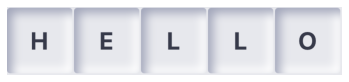

In [4]:
display_word("hello")

In [5]:
def compare_words(query_word, answer_word):
    res = []
    pos_not_found = []
    letters_not_found = []
    for (i, letter1), letter2 in zip(enumerate(query_word), answer_word):
        if letter1 == letter2:
            res.append('2')
        else:
            res.append('0')
            pos_not_found.append(i)
            letters_not_found.append(letter2)
    for i in pos_not_found:
        if query_word[i] in letters_not_found:
            res[i] = "1"
            letters_not_found.remove(query_word[i])
    return "".join(res)

In [6]:
compare_words("raise", "gorge")

'10002'

$ score(word) = \sum_{letter  \in  word}\frac{1}{rank(letter)} $

In [7]:
def filter_words(possible_words, word, comparison_string):
    new_possible_words = []
    for w in possible_words:
        if compare_words(word, w) == comparison_string:
            new_possible_words.append(w)
    return new_possible_words

In [8]:
print(filter_words(possible_answers, "raise", "10002"))

['borne', 'broke', 'brute', 'chore', 'creme', 'crepe', 'crone', 'crude', 'curve', 'drone', 'drove', 'erode', 'force', 'forge', 'forte', 'froze', 'genre', 'gorge', 'grope', 'grove', 'horde', 'merge', 'nerve', 'ombre', 'probe', 'prone', 'prove', 'prude', 'prune', 'puree', 'purge', 'there', 'three', 'trope', 'trove', 'truce', 'verge', 'verve', 'where', 'wrote']


In [9]:
letters_by_frequency = "eariotnslcudpmhgbfywkvxzjq"
letters_scores = {letter: 1/(i+1) for i, letter in enumerate(letters_by_frequency)}
    
def score_word(word):
    score = 0
    for letter in set(word):
        score += letters_scores[letter]
    return score

In [10]:
print("raise:", score_word("raise"))
print("bumpy:", score_word("bumpy"))

raise: 2.208333333333333
bumpy: 0.3507158476198724


In [11]:
def solver(comparison_string, word, possible_words):
    possible_words = filter_words(possible_words, word, comparison_string)
    if len(possible_words) == 0:
        print("No possible word in vocabulary.")
        return "", []
    else:
        words_sorted = sorted(possible_words, key=score_word, reverse=True)
        word = words_sorted[0]
        return word, possible_words

def solver_interactive(letter_1, letter_2, letter_3, letter_4, letter_5,
                       next_word=False, restart=False, solver=None):
    if restart:
        global word
        global possible_words
        restart = False
        restart_button.value = False
        for radio_button in radio_buttons:
            radio_button.value = "0"
        possible_words = possible_answers
        word = starting_word
        display_word(word)
    if next_word:
        next_word = False
        next_word_button.value = False
        comparison_string = letter_1 + letter_2 + letter_3 + letter_4 + letter_5
        word, possible_words = solver(comparison_string, word, possible_words)
        display_word(word)

## Improved solving method

In [12]:
def score_word_improved(query_word, possible_words):
    nb_words = len(possible_words)
    comparison_dict = defaultdict(int)
    for word in possible_words:
        comparison_dict[compare_words(query_word, word)] += 1
    return sum(word_count / nb_words * word_count for word_count in comparison_dict.values())

In [37]:
def best_starting_word(possible_guesses, possible_answers, topn=20):
    word_scores = []
    for word in tqdm(possible_guesses):
        word_scores.append((word, score_word_improved(word, possible_answers)))
    word_scores = sorted(word_scores, key=lambda x: x[1])
    for i in range(topn):
        print(f"{word_scores[i][0]} : {word_scores[i][1]}")

In [38]:
best_starting_word(words_allowed_guesses, possible_answers,topn=10)


  0%|          | 0/12972 [00:00<?, ?it/s]

roate : 60.42462203023761
raise : 61.00086393088555
raile : 61.3308855291577
soare : 62.301079913606905
arise : 63.72570194384452
irate : 63.77926565874733
orate : 63.890712742980604
ariel : 65.28768898488111
arose : 66.02116630669536
raine : 67.05615550755918


In [15]:
def solver_improved(comparison_string, word, possible_words):
    possible_words = filter_words(possible_words, word, comparison_string)
    if len(possible_words) == 0:
        print("No possible word in vocabulary.")
        return "", []
    else:
        words_sorted = sorted(possible_words, key=lambda x: score_word_improved(x, possible_words))
        word = words_sorted[0]
        return word, possible_words
    
    
def solver_super_improved(comparison_string, word, possible_words):
    possible_words = filter_words(possible_words, word, comparison_string)
    if len(possible_words) == 0:
        print("No possible word in vocabulary.")
        return "", []
    else:
        if len(possible_words) <= 3:
            words_sorted = sorted(possible_words, key=lambda x: score_word_improved(x, possible_words))
        else:
            words_sorted = sorted(words_allowed_guesses, key=lambda x: score_word_improved(x, possible_words))
        word = words_sorted[0]
        return word, possible_words

## Interactive solver

In [16]:
possibilities = [("Not in word", "0"), ("In word, wrong spot", "1"), ("In word, correct spot", "2")]
radio_buttons = []
for i in range(5):
    radio_button = widgets.RadioButtons(options=possibilities, value="0", description=f"Letter {i+1}:",
                                        layout={'width': 'max-content'})
    radio_buttons.append(radio_button)
next_word_button = widgets.ToggleButton(value=False, description='Next word')
restart_button = widgets.ToggleButton(value=True, description='Restart')
solver_button = widgets.Dropdown(options=[("Base solver", solver), ("Improved solver", solver_improved),
                                          ("Super improved solver", solver_super_improved) ])
first_vbox = widgets.VBox([radio_buttons[0], next_word_button])
second_vbox = widgets.VBox([radio_buttons[1], restart_button])
third_vbox = widgets.VBox([radio_buttons[2], solver_button])
ui = widgets.HBox([first_vbox, second_vbox, third_vbox] + radio_buttons[3:], box_style="info")

buttons_dict = {f"letter_{i+1}": radio_buttons[i] for i in range(5)}
buttons_dict["next_word"] = next_word_button
buttons_dict["restart"] = restart_button
buttons_dict["solver"] = solver_button

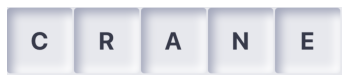

HBox(box_style='info', children=(VBox(children=(RadioButtons(description='Letter 1:', layout=Layout(width='max…

Output()

In [27]:
starting_word = "crane"
possible_words = possible_answers

restart_button.value = True
out = interactive_output(solver_interactive, buttons_dict)
display(ui, out)

## Evalutating solutions

In [18]:
def test_solution(answer_word, solver, starting_word="tares"):
    word = starting_word
    possible_words = possible_answers
    attempts = 1
    while attempts < 20:
        if word == answer_word:
            return attempts
        attempts += 1
        comparison_string = compare_words(word, answer_word)
        word, possible_words = solver(comparison_string, word, possible_words)
    return attempts

def evaluate_solver(possible_words, solver, starting_word="mount"):
    solves = []
    for word in tqdm(possible_answers):
        solves.append((word, test_solution(word, solver, starting_word=starting_word)))
    mean_attempts = sum([solve[1] for solve in solves])/len(solves)
    print(f"Mean number of attempts: {mean_attempts}")
    failed = [solve[0] for solve in solves if solve[1] > 6]
    print(f"Failed words (more than 6 attempts): {len(failed)}")
    print(", ".join(failed))

In [19]:
evaluate_solver(possible_answers, solver, starting_word="raise")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.8168466522678184
Failed words (more than 6 attempts): 28
awash, bezel, boxer, brave, brook, daddy, ferry, found, foyer, frown, fully, hatch, hunch, jaunt, joker, jolly, kitty, level, mammy, poppy, shave, swash, swore, taste, waver, weave, willy, wound


In [20]:
evaluate_solver(possible_answers, solver, starting_word="tares")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.8220302375809934
Failed words (more than 6 attempts): 24
boxer, catch, crack, eagle, ferry, found, freed, frown, hatch, jaunt, jolly, kitty, krill, nanny, rearm, roger, rover, sever, shave, waver, weave, wight, willy, wound


In [21]:
evaluate_solver(possible_answers, solver_improved, starting_word="roate")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.5939524838012957
Failed words (more than 6 attempts): 12
goner, homer, patch, pound, sound, stash, vaunt, waste, watch, wight, willy, wound


In [22]:
evaluate_solver(possible_answers, solver_improved, starting_word="roate")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.5939524838012957
Failed words (more than 6 attempts): 12
goner, homer, patch, pound, sound, stash, vaunt, waste, watch, wight, willy, wound


In [23]:
evaluate_solver(possible_answers, solver_improved, starting_word="crane")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.5779697624190065
Failed words (more than 6 attempts): 10
crazy, foyer, jolly, pound, shave, vaunt, waste, watch, willy, wound


In [28]:
test_solution("audio",solver_super_improved,starting_word="crane")

3

In [29]:
test_solution("alone",solver_super_improved,starting_word="crane")

2